In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/05 10:39:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [30]:
# Load Dataset
file = 'HeartDataOL.csv'
df = spark.read.csv(file, header=True, inferSchema=True)

In [31]:
# Displaying the first few rows
df.show()

+---+---+------+------+------+-----+-----+-----------+-------+-----+-------+------+------+
| id|age|gender|height|weight|ap_hi|ap_lo|cholesterol|glucose|smoke|alcohol|active|cardio|
+---+---+------+------+------+-----+-----+-----------+-------+-----+-------+------+------+
|  0| 50|     0|   168|  62.0|  110|   80|          1|      1|    0|   null|     1|     0|
|  1| 55|     1|   156|  85.0|  140|   90|          3|      1|    0|      0|     1|     1|
|  2| 52|     1|   165|  64.0|  130|   70|          3|      1|    0|      0|     0|     1|
|  3| 48|     0|   169|  82.0|  150|  100|          1|      1|    0|      0|     1|     1|
|  4| 48|     1|   156|  56.0|  100|   60|          1|      1|    0|      0|     0|     0|
|  5| 60|     1|   151|  67.0|  120|   80|          2|      2|    0|      0|     0|     0|
|  6| 61|     1|   157|  93.0|  130|   80|          3|      1|    0|   null|     1|     0|
|  7| 62|     0|   178|  95.0|  130|   90|          3|      3|    0|      0|     1|     1|

In [32]:
# Getting DataFrame shape (rows and columns count)
print((df.count(), len(df.columns)))

(70000, 13)


In [33]:
# Displaying DataFrame info
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- glucose: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alcohol: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



In [34]:
from pyspark.sql.functions import round, col

# Rounding values to 2 decimal places (for select columns)
rounded_desc = df.select(df.columns).describe()
for col_name in rounded_desc.columns[1:]:  # skip the summary column
    rounded_desc = rounded_desc.withColumn(col_name, round(col(col_name), 2))
rounded_desc.show()


+-------+-------+-------+-------+-------+-------+-------+-------+-----------+-------+-------+-------+-------+-------+
|summary|     id|    age| gender| height| weight|  ap_hi|  ap_lo|cholesterol|glucose|  smoke|alcohol| active| cardio|
+-------+-------+-------+-------+-------+-------+-------+-------+-----------+-------+-------+-------+-------+-------+
|  count|70000.0|69999.0|70000.0|70000.0|69999.0|69996.0|69996.0|    69996.0|69996.0|69993.0|69992.0|69997.0|69997.0|
|   mean|34999.5|  53.34|   0.65| 164.35|  74.21| 128.84|  96.66|       1.37|   1.23|   0.09|   0.05|    0.8|    0.5|
| stddev|20207.4|   6.88|   0.48|   8.35|  14.49| 154.06| 188.56|       0.68|   0.57|   0.28|   0.23|    0.4|    0.5|
|    min|    0.0|  -60.0|    0.0|   10.0|    7.0| -150.0|  -70.0|        1.0|    1.0|    0.0|    0.0|    0.0|    0.0|
|    max|69999.0|  158.0|    1.0|  282.0|  380.0|16020.0|11000.0|        3.0|    3.0|    1.0|    1.0|    1.0|    1.0|
+-------+-------+-------+-------+-------+-------+-------

In [35]:
from pyspark.sql.functions import desc

# Value counts for categorical columns
df.groupBy("gender").count().orderBy(desc("count")).show()
df.groupBy("cholesterol").count().orderBy(desc("count")).show()
df.groupBy("glucose").count().orderBy(desc("count")).show()
df.groupBy("smoke").count().orderBy(desc("count")).show()
df.groupBy("alcohol").count().orderBy(desc("count")).show()
df.groupBy("active").count().orderBy(desc("count")).show()
df.groupBy("cardio").count().orderBy(desc("count")).show()


+------+-----+
|gender|count|
+------+-----+
|     1|45530|
|     0|24470|
+------+-----+

+-----------+-----+
|cholesterol|count|
+-----------+-----+
|          1|52381|
|          2| 9549|
|          3| 8066|
|       null|    4|
+-----------+-----+

+-------+-----+
|glucose|count|
+-------+-----+
|      1|59475|
|      3| 5331|
|      2| 5190|
|   null|    4|
+-------+-----+

+-----+-----+
|smoke|count|
+-----+-----+
|    0|63824|
|    1| 6169|
| null|    7|
+-----+-----+

+-------+-----+
|alcohol|count|
+-------+-----+
|      0|66228|
|      1| 3764|
|   null|    8|
+-------+-----+

+------+-----+
|active|count|
+------+-----+
|     1|56261|
|     0|13736|
|  null|    3|
+------+-----+

+------+-----+
|cardio|count|
+------+-----+
|     0|35020|
|     1|34977|
|  null|    3|
+------+-----+



In [15]:
# Correlation
print("Correlation between cardio and smoke:", df.stat.corr("cardio", "smoke"))

Correlation between cardio and smoke: -0.01546817169232994


In [16]:
# If display the correlation matrix, it's a bit more complex in Spark
for col1 in df.columns:
    for col2 in df.columns:
        print(f"Correlation between {col1} and {col2}: {df.stat.corr(col1, col2):.2f}")

Correlation between id and id: 1.00
Correlation between id and age: 0.00
Correlation between id and gender: -0.00
Correlation between id and height: -0.00
Correlation between id and weight: -0.00
Correlation between id and ap_hi: 0.00
Correlation between id and ap_lo: -0.00
Correlation between id and cholesterol: 0.01
Correlation between id and glucose: 0.00
Correlation between id and smoke: -0.00
Correlation between id and alcohol: 0.00
Correlation between id and active: 0.00
Correlation between id and cardio: 0.00
Correlation between age and id: 0.00
Correlation between age and age: 1.00
Correlation between age and gender: 0.02
Correlation between age and height: -0.08
Correlation between age and weight: 0.05
Correlation between age and ap_hi: 0.02
Correlation between age and ap_lo: 0.02
Correlation between age and cholesterol: 0.15
Correlation between age and glucose: 0.10
Correlation between age and smoke: -0.05
Correlation between age and alcohol: -0.03
Correlation between age and

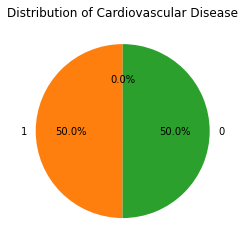

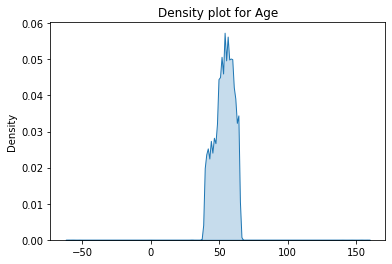

TypeError: '<=' not supported between instances of 'int' and 'NoneType'

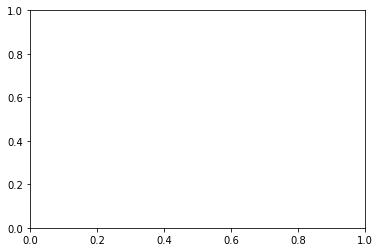

In [50]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName('basics').getOrCreate()
file_path = 'HeartDataOL.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Cardiovascular Pie Chart
cardio_counts = df.groupBy("cardio").count().collect()
labels = [row["cardio"] for row in cardio_counts]
sizes = [row["count"] for row in cardio_counts]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Cardiovascular Disease')
plt.show()

# Function to plot density and histogram for continuous columns
def plot_density_and_histogram(data, column_name):
    # Density plot
    sns.kdeplot(data, shade=True)
    plt.title(f'Density plot for {column_name}')
    plt.show()
    
    # Histogram
    plt.hist(data, bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.show()

# Age
age_data = df.select("age").rdd.flatMap(lambda x: x).collect()
plot_density_and_histogram(age_data, "Age")

# Height
height_data = df.select("height").rdd.flatMap(lambda x: x).collect()
plot_density_and_histogram(height_data, "Height")

# Weight
weight_data = df.select("weight").rdd.flatMap(lambda x: x).collect()
plot_density_and_histogram(weight_data, "Weight")

# Function to plot bar chart for categorical columns
def plot_bar_chart(column_name):
    column_counts = df.groupBy(column_name).count().collect()
    labels = [row[column_name] for row in column_counts]
    counts = [row["count"] for row in column_counts]
    sns.barplot(x=labels, y=counts)
    plt.title(f'Distribution of {column_name}')
    plt.show()

# Gender, Smoke, Active, Cardio, Glucose, Cholesterol, Alcohol
for column in ['gender', 'smoke', 'active', 'cardio', 'glucose', 'cholesterol', 'alcohol']:
    plot_bar_chart(column)


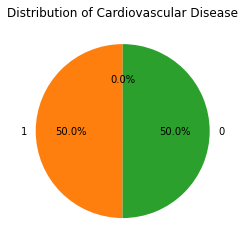

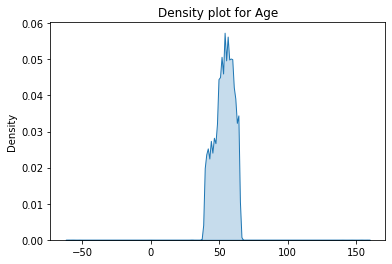

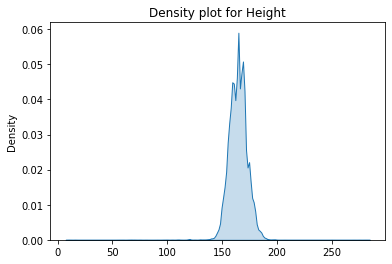

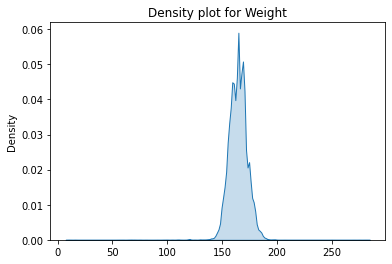

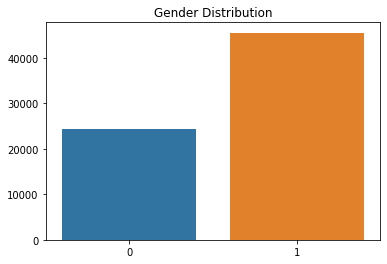

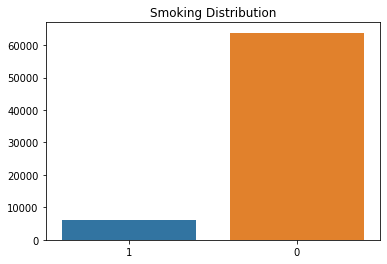

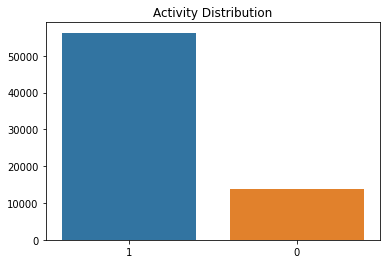

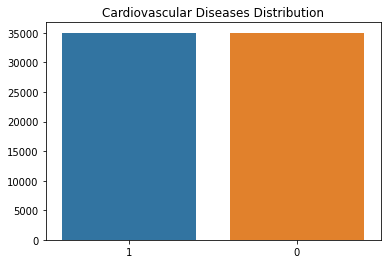

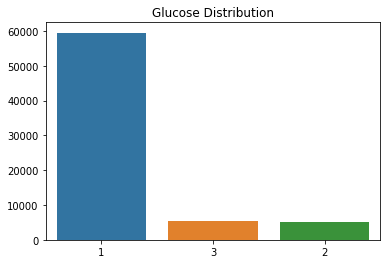

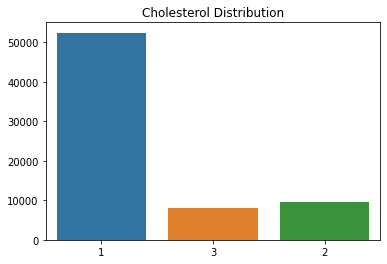

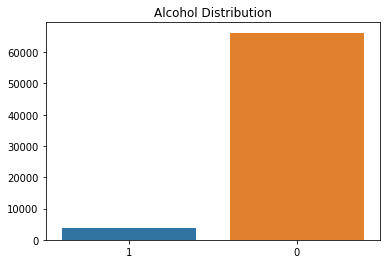

In [51]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName('basics').getOrCreate()
file_path = 'HeartDataOL.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Cardiovascular Pie Chart
cardio_counts = df.groupBy("cardio").count().collect()
labels = [row["cardio"] for row in cardio_counts]
sizes = [row["count"] for row in cardio_counts]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Cardiovascular Disease')
plt.show()

# Age Density Plot
age_data = df.select("age").rdd.flatMap(lambda x: x).collect()
sns.kdeplot(age_data, shade=True)
plt.title('Density plot for Age')
plt.show()

# Height Density Plot
height_data = df.select("height").rdd.flatMap(lambda x: x).collect()
sns.kdeplot(height_data, shade=True)
plt.title('Density plot for Height')
plt.show()

# Weight Density Plot
height_data = df.select("height").rdd.flatMap(lambda x: x).collect()
sns.kdeplot(height_data, shade=True)
plt.title('Density plot for Weight')
plt.show()

# ... and so on for other columns

# Gender Distribution
gender_counts = df.groupBy("gender").count().collect()
labels = [row["gender"] for row in gender_counts]
counts = [row["count"] for row in gender_counts]
sns.barplot(x=labels, y=counts)
plt.title('Gender Distribution')
plt.show()

# ... and so on for other categorical columns

# Smoke Distribution
smoke_counts = df.groupBy("smoke").count().collect()
labels = [row["smoke"] for row in smoke_counts]
counts = [row["count"] for row in smoke_counts]
sns.barplot(x=labels, y=counts)
plt.title('Smoking Distribution')
plt.show()

# Active Distribution
active_counts = df.groupBy("active").count().collect()
labels = [row["active"] for row in active_counts]
counts = [row["count"] for row in active_counts]
sns.barplot(x=labels, y=counts)
plt.title('Activity Distribution')
plt.show()

# Cardiovascular Diseases Distribution
cardio_counts = df.groupBy("cardio").count().collect()
labels = [row["cardio"] for row in cardio_counts]
counts = [row["count"] for row in cardio_counts]
sns.barplot(x=labels, y=counts)
plt.title('Cardiovascular Diseases Distribution')
plt.show()

# Glucose Distribution
glucose_counts = df.groupBy("glucose").count().collect()
labels = [row["glucose"] for row in glucose_counts]
counts = [row["count"] for row in glucose_counts]
sns.barplot(x=labels, y=counts)
plt.title('Glucose Distribution')
plt.show()

# Cholesterol Distribution
cholesterol_counts = df.groupBy("cholesterol").count().collect()
labels = [row["cholesterol"] for row in cholesterol_counts]
counts = [row["count"] for row in cholesterol_counts]
sns.barplot(x=labels, y=counts)
plt.title('Cholesterol Distribution')
plt.show()

# Alcohol Distribution
alcohol_counts = df.groupBy("alcohol").count().collect()
labels = [row["alcohol"] for row in alcohol_counts]
counts = [row["count"] for row in alcohol_counts]
sns.barplot(x=labels, y=counts)
plt.title('Alcohol Distribution')
plt.show()




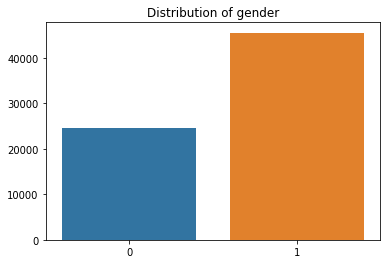

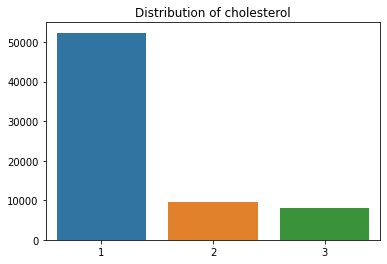

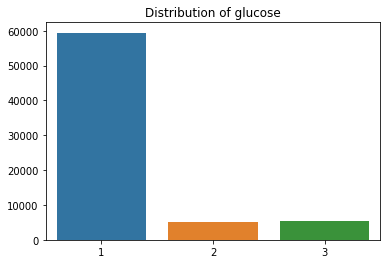

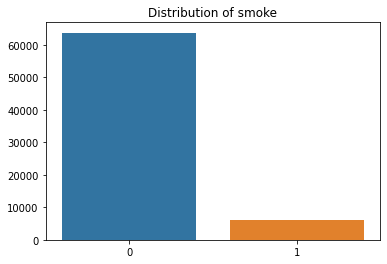

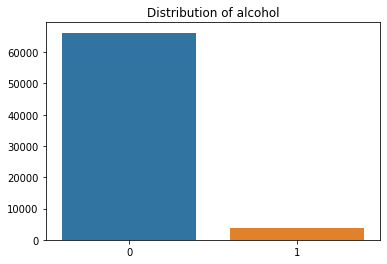

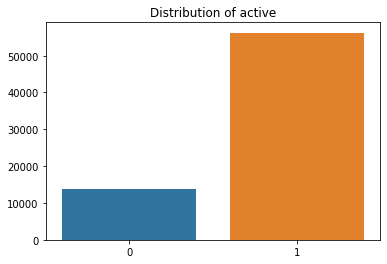

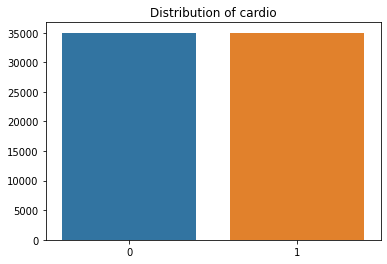

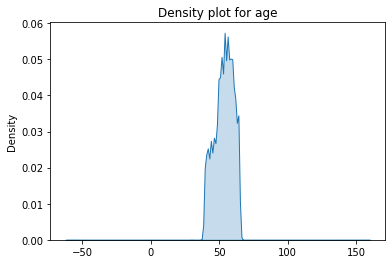

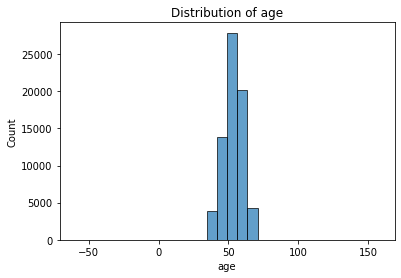

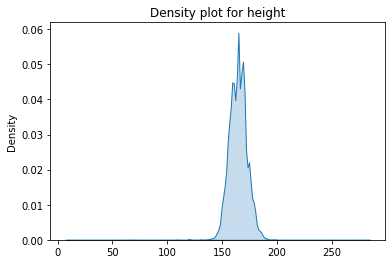

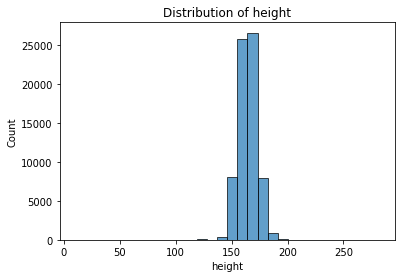

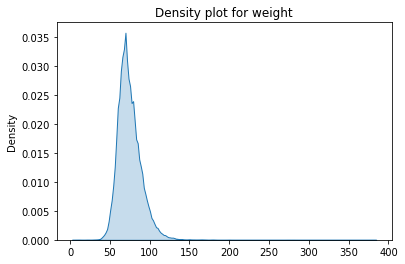

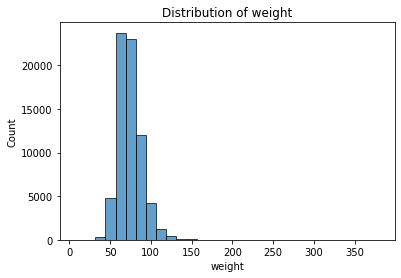

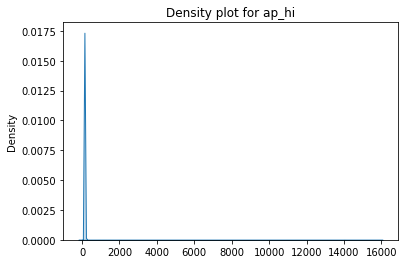

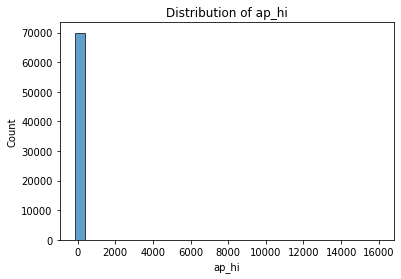

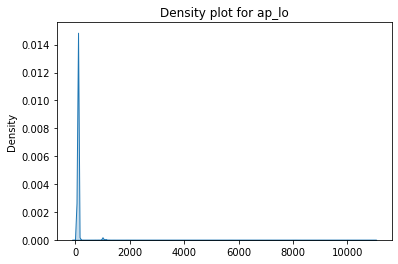

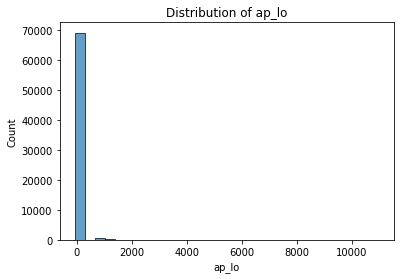

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out rows with None values for each column
for column in df2.columns:
    df2 = df2.filter(col(column).isNotNull())

# Function to plot categorical columns
def plot_categorical(column_name):
    column_counts = df2.groupBy(column_name).count().orderBy(column_name).collect()
    labels = [row[column_name] for row in column_counts]
    counts = [row["count"] for row in column_counts]
    sns.barplot(x=labels, y=counts)
    plt.title(f'Distribution of {column_name}')
    plt.show()

# Function to plot continuous columns with density plot and histogram
def plot_continuous(column_name):
    column_data = df2.select(column_name).rdd.flatMap(lambda x: x).collect()
    
    # Density plot
    sns.kdeplot(column_data, shade=True)
    plt.title(f'Density plot for {column_name}')
    plt.show()
    
    # Histogram
    plt.hist(column_data, bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.show()

# List of categorical columns
categorical_columns = ['gender', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'cardio']

# List of continuous columns
continuous_columns = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Plotting
for column in categorical_columns:
    plot_categorical(column)

for column in continuous_columns:
    plot_continuous(column)


In [43]:
from pyspark.sql.functions import round, col

# Rounding values to 2 decimal places (for select columns)
rounded_desc = df2.select(df.columns).describe()
for col_name in rounded_desc.columns[1:]:  # skip the summary column
    rounded_desc = rounded_desc.withColumn(col_name, round(col(col_name), 2))
rounded_desc.show()

+-------+--------+-------+-------+-------+-------+-------+-------+-----------+-------+-------+-------+-------+-------+
|summary|      id|    age| gender| height| weight|  ap_hi|  ap_lo|cholesterol|glucose|  smoke|alcohol| active| cardio|
+-------+--------+-------+-------+-------+-------+-------+-------+-----------+-------+-------+-------+-------+-------+
|  count| 69961.0|69961.0|69961.0|69961.0|69961.0|69961.0|69961.0|    69961.0|69961.0|69961.0|69961.0|69961.0|69961.0|
|   mean|35018.93|  53.34|   0.65| 164.35|  74.21| 128.84|  96.67|       1.37|   1.23|   0.09|   0.05|    0.8|    0.5|
| stddev|20196.26|   6.88|   0.48|   8.35|  14.49|  154.1| 188.61|       0.68|   0.57|   0.28|   0.23|    0.4|    0.5|
|    min|     1.0|  -60.0|    0.0|   10.0|    7.0| -150.0|  -70.0|        1.0|    1.0|    0.0|    0.0|    0.0|    0.0|
|    max| 69999.0|  158.0|    1.0|  282.0|  380.0|16020.0|11000.0|        3.0|    3.0|    1.0|    1.0|    1.0|    1.0|
+-------+--------+-------+-------+-------+------

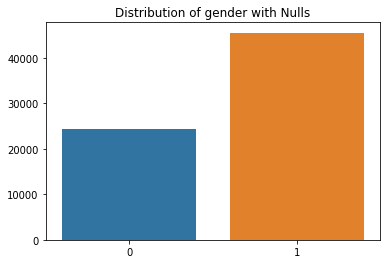

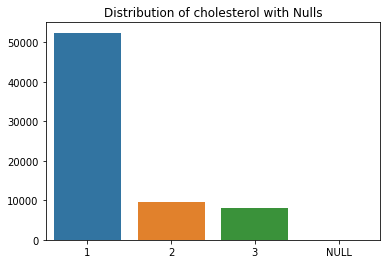

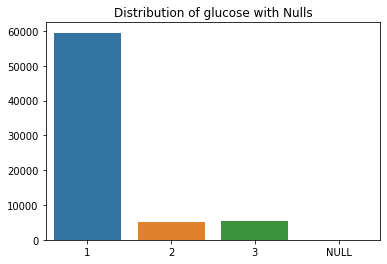

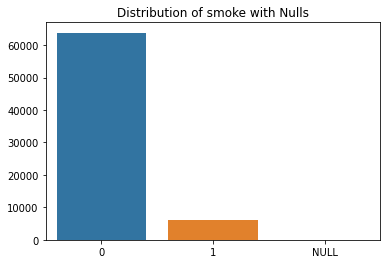

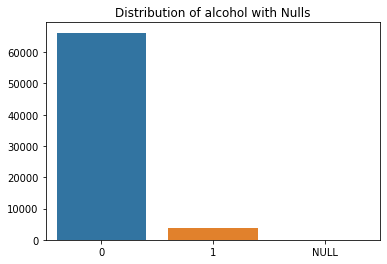

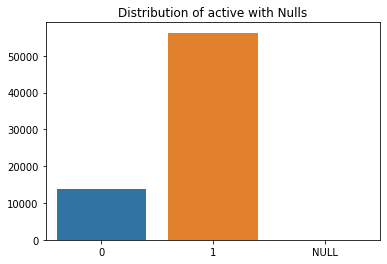

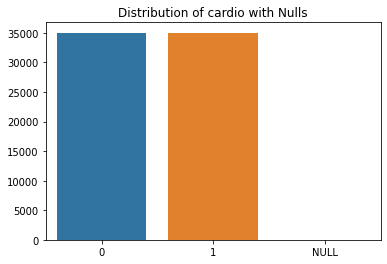

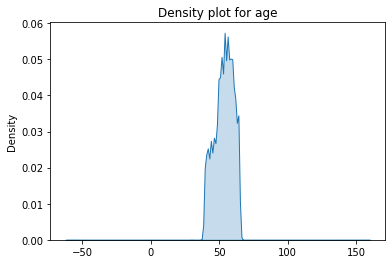

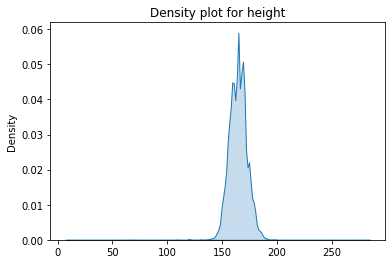

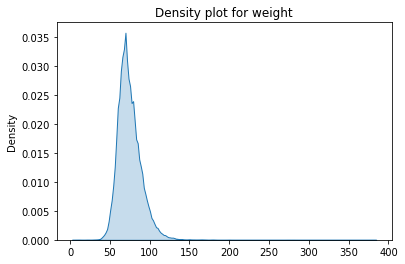

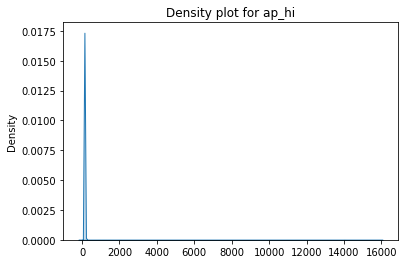

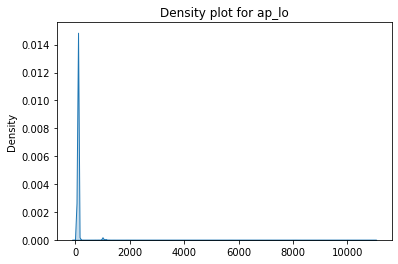

In [44]:
from pyspark.sql.functions import isnan, when, count, col

# Create a copy of df for df3
df3 = df

# Using the functions defined previously to plot

# List of categorical columns
categorical_columns = ['gender', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'cardio']

# List of continuous columns
continuous_columns = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Function to plot categorical columns with null values considered
def plot_categorical_with_null(column_name):
    # Handling nulls by converting them to string "NULL"
    column_counts = df3.withColumn(column_name, when(col(column_name).isNull(), "NULL").otherwise(col(column_name))) \
                       .groupBy(column_name).count().orderBy(column_name).collect()
    labels = [row[column_name] for row in column_counts]
    counts = [row["count"] for row in column_counts]
    sns.barplot(x=labels, y=counts)
    plt.title(f'Distribution of {column_name} with Nulls')
    plt.show()

# Plotting
for column in categorical_columns:
    plot_categorical_with_null(column)

for column in continuous_columns:
    plot_continuous(column)


In [45]:
from pyspark.sql.functions import round, col

# Rounding values to 2 decimal places (for select columns)
rounded_desc = df3.select(df.columns).describe()
for col_name in rounded_desc.columns[1:]:  # skip the summary column
    rounded_desc = rounded_desc.withColumn(col_name, round(col(col_name), 2))
rounded_desc.show()

+-------+-------+-------+-------+-------+-------+-------+-------+-----------+-------+-------+-------+-------+-------+
|summary|     id|    age| gender| height| weight|  ap_hi|  ap_lo|cholesterol|glucose|  smoke|alcohol| active| cardio|
+-------+-------+-------+-------+-------+-------+-------+-------+-----------+-------+-------+-------+-------+-------+
|  count|70000.0|69999.0|70000.0|70000.0|69999.0|69996.0|69996.0|    69996.0|69996.0|69993.0|69992.0|69997.0|69997.0|
|   mean|34999.5|  53.34|   0.65| 164.35|  74.21| 128.84|  96.66|       1.37|   1.23|   0.09|   0.05|    0.8|    0.5|
| stddev|20207.4|   6.88|   0.48|   8.35|  14.49| 154.06| 188.56|       0.68|   0.57|   0.28|   0.23|    0.4|    0.5|
|    min|    0.0|  -60.0|    0.0|   10.0|    7.0| -150.0|  -70.0|        1.0|    1.0|    0.0|    0.0|    0.0|    0.0|
|    max|69999.0|  158.0|    1.0|  282.0|  380.0|16020.0|11000.0|        3.0|    3.0|    1.0|    1.0|    1.0|    1.0|
+-------+-------+-------+-------+-------+-------+-------